In [1]:
import sys,os

sys.path.append('/home/arash/ProjectVR/')

import importlib
import deepsurv
import json
import time
import numpy as np
import pandas as pd
import pickle
import theano.tensor
import lasagne
import optunity

#import logging
#from logging import handlers
#from sklearn.model_selection import train_test_split

importlib.reload(deepsurv)

from deepsurv import deep_surv, utils

#from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Load trained network and data

In [2]:
#deepsurv formatted data    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtest', 'rb') as f:
    xtest=pickle.load(f)

with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrain', 'rb') as f:
    xtrain=pickle.load(f)
    
#dataframe data with wait times and col names    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctest', 'rb') as f:   
    NCtest=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctrain', 'rb') as f:   
    NCtrain=pickle.load(f) 
    
network=deep_surv.load_model_from_json(model_fp = '/home/arash/ProjectVR/models/Deepwait100epochsTuned',
                     weights_fp = '/home/arash/ProjectVR/models/deepwait_weights_100_epochs.npz')

Loading json model: {"n_in": 19, "learning_rate": 0.0008208386784744157, "hidden_layers_sizes": [90, 90], "lr_decay": 0.000551240234375, "activation": "rectify", "dropout": 0.0, "batch_norm": true, "standardize": false}


### Predicting event times
To predict the time of event for instances, having an estimation of partial hazard is not sufficient. First, baseline hazard is required to estimate hazard function, which will be a function of time and covariates. The next step would be to calculate survival function. Finally, expected wait time can be calculated by:
\begin{equation}
    E(t)=\int_{t=0}^\infty S(t)dt
\end{equation}
### Baseline Hazard
Baseline hazard is interpreted as hazard function regardless of the values of the covariates (or when they are all 0). Different methods have been suggested in the literature for an estimation of baseline hazard. For CPH, the method used in python package is extracted from Breslow [1972]. In their method, "the underlying survival distribution is
parameterized as a continuous one, having constant hazards $\lambda_i$ between each
pair $t_{i-1}$ to $t_i$ of distinct relapse times. If all withdrawals, or censored observations, which
occur in the interval $(t_i, t_{i+1})$ are adjusted to have occurred at $t_i$ , the ML estimator of
$\lambda$ in terms of $\beta$ coefficients at time $t_i$ by:
\begin{equation}
\label{eq:9}
    \lambda_i=\frac{m_i}{\displaystyle \sum_{j: T_j>T_i } e^{\beta*Z_j}}
\end{equation}
in which $m_i$ is the number of events at time $t_i$, Equation above is provided for CPH. In deepwait, we replace the partial hazards part with the exp of the output of our network 

deepwait predicts wait time for autonmous vehicle, so the data used will be solely those ones that the car can observe, not sociodemographic etc, and the baseline hazards are calculated based on training data, as the car will not know about other pedestrians at risk etc.

In [196]:
parthazards = network.hazard(xtrain[:,0:network.hyperparams['n_in']])               #calculate partial hazard 

NCtrain['Partial Hazards'] = parthazards

In [43]:
eventtimes = NCtrain.sort_values(by=['Wait Time (s)'])['Wait Time (s)'].unique() #sorted event times

In [44]:
#m_i in the baseline hazard formula, sorted by time
eventnum = NCtrain['Wait Time (s)'].value_counts().sort_index() 

In [322]:
basehazard=[]
for i in range(len(eventtimes)):
    basehazard.append(
        list(eventnum)[i] / (sum(NCtrain['Partial Hazards'][NCtrain['Wait Time (s)'] >= eventtimes[i]]))
    )

In [323]:
# creating a df of hazards
eventsDF = pd.DataFrame({'Times': eventtimes, 'Counts': eventnum, 'Base Hazard': basehazard })

eventsDF=eventsDF.reset_index()

eventsDF=eventsDF.drop(columns=['index'])

In [324]:
eventsDF.head()

,Times,Counts,Base Hazard
0,0.000000,175,0.026315
1,0.100028,1,0.000178
2,0.100080,1,0.000179
3,0.100100,1,0.000179
4,0.100170,1,0.000179


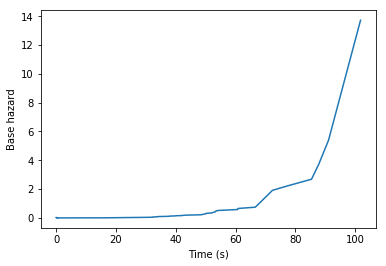

In [325]:
plt.xlabel('Time (s)')
plt.ylabel('Base hazard')
plt.plot(eventsDF['Times'],eventsDF['Base Hazard'])
plt.show()


In [429]:
#Cumulative Hazard function (integral of baseline*partial over time)

discreteTimes = np.arange(0.0, max(eventsDF['Times']),0.1)  #define discrete times with 0.1 timesteps
discreteBase = np.interp(discreteTimes,eventsDF['Times'],eventsDF['Base Hazard'])
def cumhazard (x):    #x: covariates of the instance we are looking into
    parthazard = network.hazard(x) 
    hazard = parthazard * discreteBase
    cumhazard = np.cumsum(hazard[0])
    return cumhazard
    

    

In [432]:
cumhazard(xtrain[0:1,0:network.hyperparams['n_in']])

array([3.14828673e-02, 3.17051163e-02, 3.19771987e-02, ...,
       2.05994225e+03, 2.07620080e+03, 2.09255246e+03])

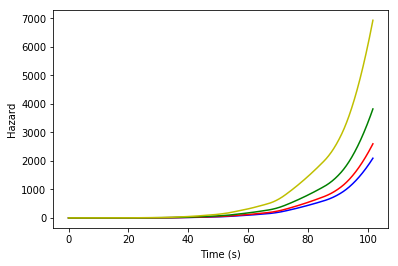

In [433]:
plt.xlabel('Time (s)')
plt.ylabel('Hazard')
plt.plot(discreteTimes,cumhazard(xtrain[0:1,0:network.hyperparams['n_in']]),'b')
plt.plot(discreteTimes, cumhazard(xtrain[1:2,0:network.hyperparams['n_in']]), 'r')
plt.plot(discreteTimes, cumhazard(xtrain[2:3,0:network.hyperparams['n_in']]), 'g')
plt.plot(discreteTimes, cumhazard(xtrain[3:4,0:network.hyperparams['n_in']]), 'y')
plt.show()


In [437]:
def survfunction(cumhazard,t):
    steps = int(np.round(t/0.1,0))
    return np.exp(-sum(0.1 * cumhazard[0:steps]))     #0.1: dz

In [438]:
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])
for n in range(xtrain.shape[0]):
    surv=[]
    hazardarray = cumhazard(xtrain[n:n+1,0:network.hyperparams['n_in']])
    for t in discreteTimes:
        surv.append(survfunction(hazardarray,t))
    expected = np.trapz(surv,discreteTimes)
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)

In [379]:
predictedwait.index=pd.DataFrame(NCtrain['Wait Time (s)']).index


In [ ]:
x=predictedwait-pd.DataFrame(NCtrain['Wait Time (s)'])

In [414]:
x

,Wait Time (s)
2856,32.796577
2161,17.417763
1711,29.010801
678,14.953612
1689,23.202542
417,20.394154
1763,19.136436
955,29.881551
423,17.845079
624,20.276606


In [404]:
TSS

159947.99572859638

In [397]:
RSS = np.linalg.norm(predictedwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2   #residual sum of squares

In [400]:
AVG = pd.DataFrame(NCtrain['Wait Time (s)']).mean()

In [402]:
TSS = np.linalg.norm(pd.DataFrame(NCtrain['Wait Time (s)'])-AVG)**2         #Total sum of square

R2 = 1-RSS/TSS                       #R squared

R2

-5.245644885645744

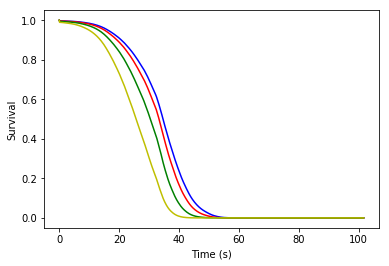

In [351]:
plt.xlabel('Time (s)')
plt.ylabel('Survival')
plt.plot(discreteTimes,surv0,'b')
plt.plot(discreteTimes,surv1,'r')
plt.plot(discreteTimes,surv2,'g')
plt.plot(discreteTimes,surv3,'y')
plt.show()

In [353]:
np.trapz(surv0,discreteTimes)

33.49591688388263

In [315]:
NCtrain.head()

,walktoshop,numcars_morethan1,mode_Car,normarrival,over50,normdens,Age_18 - 29,Snowy,Gender_Female,One way,...,FullAV,normlanewidth,Night,walktowork,normmingap,Two way with median,numcars_0,E,Wait Time (s),Partial Hazards
2856,1,0,0,0.385965,1,0.552430,0,0.0,0,0.0,...,1,1.0,0.0,0,0.0,0.0,0,1,0.69934,1.196400
2161,0,1,1,0.385965,0,0.168798,0,0.0,1,0.0,...,1,0.0,0.0,0,1.0,1.0,0,1,14.42615,1.485180
1711,0,0,0,0.000000,0,0.271100,1,0.0,1,0.0,...,1,0.0,1.0,1,0.0,1.0,0,1,0.00000,2.184082
678,1,0,0,0.000000,0,0.101662,0,0.0,0,0.0,...,1,1.0,1.0,1,0.5,0.0,1,1,9.86871,3.961653
1689,1,0,0,0.000000,0,0.271100,1,0.0,0,1.0,...,1,0.0,0.0,1,0.0,0.0,1,1,0.00000,5.018865
